# SVM Classifier

### Libraries

In [47]:
import pandas as pd
from astropy.io import fits
import numpy as np
from astropy.table import Table, vstack, MaskedColumn
from astroquery.gaia import Gaia
from scipy.stats import reciprocal, uniform
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
import os
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import sys
sys.path.append("/Users/anais/Desktop/Etudes/MASS/Nice/Courses/Mchine Learning/Project")

from plot_confusion import plot_confusion
import query

### Gaia data retrieval

In [50]:
train = query.query('training')
test = query.query('testing')

Retrieving training dataset
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
classification
star      15000
galaxy    15000
quasar    15000
Name: count, dtype: int64
Retrieving training dataset
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
classification
star      150000
galaxy    150000
quasar    150000
Name: count, dtype: int64


### Features, optimisation of hyperparameters, and classifier

In [92]:
# Feature selection
features = [
        "sinb",                  # sine of the Galactic latitude
        "parallax",               # parallax
        "pm",                     # total proper motion
        "uwe",                    # unit weight error (uwe)
        "phot_g_mean_mag",        # G band magnitude
        "bp_g",                   # colour Gbp - G
        "g_rp",                   # colour G - Grp
        "relvarg"                 # The relative variability in the G band (relvarg)
 ]

# Create training + test features sets/labels
X_train = train[features]
y_train = train['classification']

X_test = test[features]
y_test = test['classification']


# pipeline for classification with SVM
classifier = Pipeline([
    ("scaler", StandardScaler()),  # Feature scaling
    ("svc", SVC())  # SVM classifier
])

# Hyperparameter search space for SVM
param_distributions = {
    "svc__gamma": reciprocal(0.001, 0.1),
    "svc__C": uniform(1, 10),
    "svc__kernel": ['linear', 'rbf', 'poly', 'sigmoid'],
    "svc__degree": [2, 3, 4],  # Relevant for polynomial kernel
    "svc__coef0": [0, 1]       # Used in poly and sigmoid kernels
}


classifier.fit(X_train, y_train)

# Predict and evaluate on training data
y_pred_train = classifier.predict(X_train)
print("Train accuracy:", accuracy_score(y_train, y_pred_train))
print("Train classification report:\n", classification_report(y_train, y_pred_train))

# Run hyperparameter optimisation
search = RandomizedSearchCV(
        classifier,
        param_distributions=param_distributions,
        n_iter=30,
        scoring="f1_weighted",
        cv=3,
        random_state=42,
        verbose=2,
        n_jobs=-1)

search.fit(X_train, y_train)

print("Best hyperparameters:", search.best_estimator_)
print("Best F1-weighted score:", search.best_score_)

# Evaluate the best model on the test set
best_model = search.best_estimator_
y_pred_test = best_model.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred_test))
print("Test classification report:\n", classification_report(y_test, y_pred_test))


Train accuracy: 0.9987777777777778
Train classification report:
               precision    recall  f1-score   support

      galaxy       1.00      1.00      1.00     15000
      quasar       1.00      1.00      1.00     15000
        star       1.00      1.00      1.00     15000

    accuracy                           1.00     45000
   macro avg       1.00      1.00      1.00     45000
weighted avg       1.00      1.00      1.00     45000

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END svc__C=8.219987722668247, svc__coef0=1, svc__degree=3, svc__gamma=0.0010035927878780913, svc__kernel=sigmoid; total time=  11.9s
[CV] END svc__C=10.218742350231167, svc__coef0=1, svc__degree=3, svc__gamma=0.0024658447214487376, svc__kernel=linear; total time=   2.3s
[CV] END svc__C=6.867511656638483, svc__coef0=0, svc__degree=2, svc__gamma=0.00191358804876923, svc__kernel=poly; total time=  57.7s
[CV] END svc__C=4.745401188473625, svc__coef0=0, svc__degree=4, svc__gamma=0.0291063

### Confusion matrix

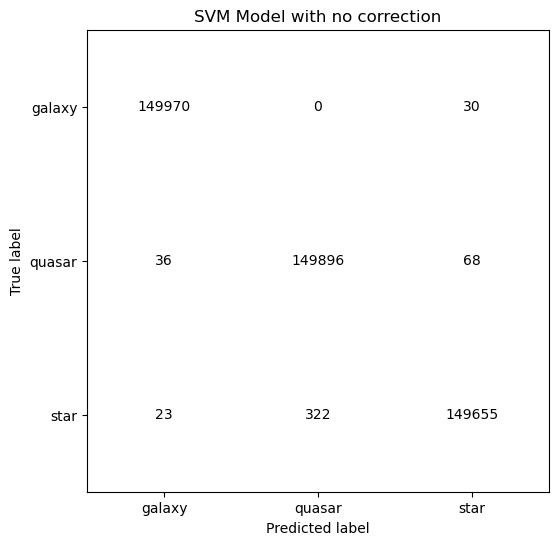

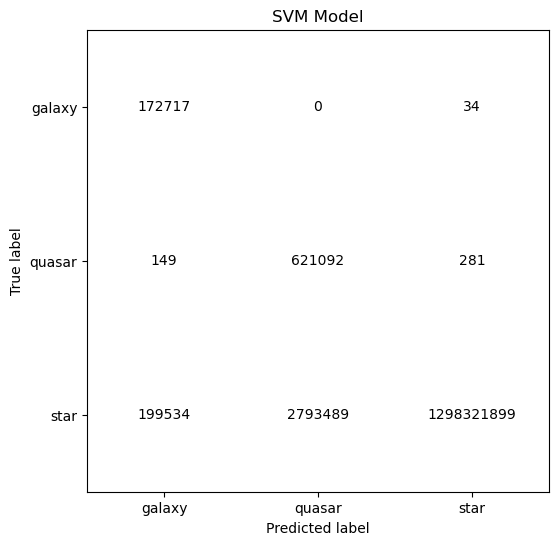

In [94]:
labels = classifier.classes_

#Confusion Matrix with no correction
conf_matrix_nocorrection = plot_confusion(y_test, y_pred_test, labels=labels, title = 'SVM Model with no correction', corrected = False, savefig = True, count = {'star':1301314924, 'quasar': 621523, 'galaxy':172752})

#Confusion Matrix with correction
conf_matrix = plot_confusion(y_test, y_pred_test, labels=labels, title = 'SVM Model', corrected = True, savefig = False, count = {'star':1301314924, 'quasar': 621523, 'galaxy':172752})


### Metrics table

In [100]:
# Plot per-class performance metrics
def plot_metrics(y_test, y_pred_test, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test)

    x = range(len(class_names))

    plt.figure(figsize=(10, 5))
    plt.bar(x, precision, width=0.25, label='Precision', align='center')
    plt.bar([i + 0.25 for i in x], recall, width=0.25, label='Recall', align='center')
    plt.bar([i + 0.5 for i in x], f1, width=0.25, label='F1 Score', align='center')
    plt.xticks([i + 0.25 for i in x], class_names)
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('Performances by class')
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

#plot_metrics(y_test, y_pred_test, class_names=["Star", "Galaxy", "Quasar"])

# Display metric in table format
def display_metrics_table(y_test, y_pred_test, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test)
    accuracy = accuracy_score(y_test, y_pred_test)

    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    accuracy_row = pd.DataFrame({
        'Class': ['Accuracy'],
        'Precision': [accuracy],
        'Recall': [accuracy],
        'F1 Score': [accuracy]
    })

    metrics_df = pd.concat([metrics_df, accuracy_row], ignore_index=True)
    print(metrics_df)

display_metrics_table(y_test, y_pred_test, class_names=["Star", "Galaxy", "Quasar"])


      Class  Precision    Recall  F1 Score
0      Star   0.999607  0.999800  0.999703
1    Galaxy   0.997856  0.999307  0.998581
2    Quasar   0.999346  0.997700  0.998522
3  Accuracy   0.998936  0.998936  0.998936


### Feature importances

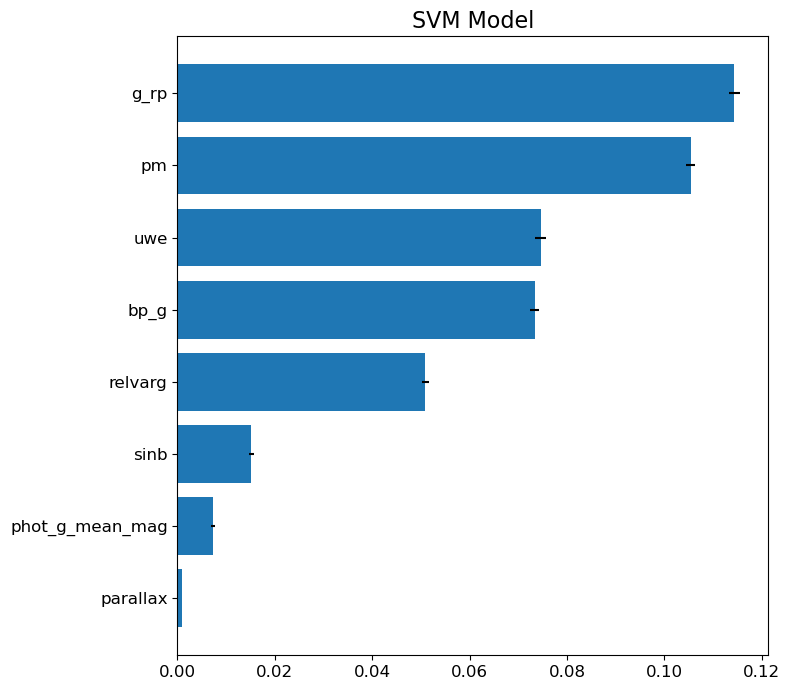

In [105]:
# Helper function to plot permutation-based feature importance
def plot_feature_importances(perm_importance_result, feat_name, savefig=True):
    fig, ax = plt.subplots(figsize=(8, 7))
    indices = perm_importance_result["importances_mean"].argsort()

    plt.barh(
        range(len(indices)),
        perm_importance_result["importances_mean"][indices],
        xerr=perm_importance_result["importances_std"][indices]
    )

    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels(feat_name[indices])
    ax.set_title("SVM Model", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()

    if savefig:
        plt.savefig('SVM_importance.png')
    plt.show()

# Shuffle data before computing permutation importance
train = shuffle(train, random_state=42)
test = shuffle(test, random_state=42)

feature_names = np.array(X_train.columns)

# Compute permutation importance on training set
perm_importance_result_train = permutation_importance(
    search.best_estimator_, X_train, y_train, n_repeats=20, random_state=42
)

plot_feature_importances(perm_importance_result_train, feature_names)